In [102]:
import pandas as pd
import wikipediaapi as api
import numpy as np
import matplotlib.pylab as plt
import wikipedia as wikip
from collections import Counter
import random as rd
import json
import requests
from statistics import mean
from bs4 import BeautifulSoup as bs
import urllib3
import re
import ast
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, QuantileTransformer

## Ersten 30 Links

In [103]:
def getOrderedLinks(wikipage):
    #try:
    http = urllib3.PoolManager()
    response = http.request("GET", wikipage)
    soup = bs(response.data)
    soup = soup.find(id="mw-content-text")
    link_list = soup.find_all("a",href=re.compile("/wiki/"))
    return link_list
    #except:
        #print(wikipage)
        
def filterLinks(soup):
    reg = re.compile("^(?!/wiki/Datei:).+")
    reg2 = re.compile("^(?!/wiki/Spezial:).+")
    reg3 = re.compile("^/wiki")
    filteredList = [e["title"] for e in soup if reg.match(e["href"]) and reg2.match(e["href"]) and reg3.match(e["href"])]
    return filteredList

def cutList(titleList, length):
    result = ((titleList[:length]))
    return list(dict.fromkeys(result))



In [104]:
wiki = api.Wikipedia('Datenanalyse', 'de')

## Speichern der Listen als Textdateien

In [105]:
def save(liste, dateipfad):
    with open(dateipfad, 'w', encoding='utf-8') as datei:
        json.dump(liste, datei, ensure_ascii=False)

In [106]:
def WikiPageView(name, granularity, date_start, date_end):
    #YYYYMMDD
    # Calling monthly page views of each species 
    address = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/user/" + name + "/" + granularity + "/" + date_start + "/" + date_end
    # Personal username for identification for the Wikipedia API
    headers = {'User-Agent': 'marek.seipel@web.de'}
    
    resp = requests.get(address, headers=headers)
    details = resp.json()
    
    return details

# Lineare Regression

In [107]:

def getTrainingsdata(p):

    page = wiki.page(p)
    fw = getOrderedLinks('https://de.wikipedia.org/wiki/' + p)
    fw = filterLinks(fw)
    fw = cutList(fw,30)

    file = WikiPageView(p, "daily", "20230101" , "20231030")
    items = file['items']

    training = np.zeros((len(items), 30))

    for i in range(len(fw)):
        file = WikiPageView(fw[i], "daily", "20230101" , "20231030")
        try:
            items = file['items']
            for j in range(len(items)):
                training[j][i] = items[j]['views']
        except(KeyError) as e:
            continue    
    y = []
    file = WikiPageView(p, "daily", "20230101" , "20231030")
    items = file['items']
    for i in range(len(items)):
        y.append(items[i]['views'])
    y = np.array(y)

    np.set_printoptions(suppress=True)

    #print(training)
    #print(y)
    return (training,y)



In [108]:

def getTestdaten(p):
    file = WikiPageView(p, "daily", "20231101" , "20231231")
    items = file['items']

    fw = getOrderedLinks('https://de.wikipedia.org/wiki/' + p)
    fw = filterLinks(fw)
    fw = cutList(fw,30)

    test = np.zeros((len(items),30))
    for i in range(len(fw)):
        file = WikiPageView(fw[i], "daily", "20231101" , "20231231")
        try:
            items = file['items']
            for j in range(len(items)):
                test[j][i] = items[j]['views']
        except(KeyError) as e:
            continue
    np.set_printoptions(suppress=True)
    return test



In [109]:

def getActualData(p):
    file = WikiPageView(p, "daily", "20231101" , "20231231")
    items = file['items']
    actual = []
    for i in range(len(items)):
        actual.append(items[i]['views'])
    return actual


def buildModel(training, y):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("model", LinearRegression(positive=True))
        ])
    #mod = GridSearchCV(estimator=pipe, param_grid={'model__n_jobs':[1,2,3,4,5,6,7,8,9,10]}, cv=4)
    mod = LinearRegression(positive=True)
    pipe.fit(training,y)
    return pipe

# Nahost

In [110]:
tupel_nahost = getTrainingsdata("Nahostkonflikt")
training_nahost = (tupel_nahost[0])
y_nahost = (tupel_nahost[1])

test_nahost= getTestdaten("Nahostkonflikt")
print(test_nahost)


mod_nahost = buildModel(training_nahost, y_nahost)
pred_nahost = mod_nahost.predict(test_nahost)
actual_nahost = getActualData("Nahostkonflikt")


print(actual_nahost)
print(pred_nahost)



[[29820. 32091. 12817. ...     0.     0.     0.]
 [24802. 25321. 10204. ...     0.     0.     0.]
 [23730. 22453. 10025. ...     0.     0.     0.]
 ...
 [ 3383.  2248.  1204. ...     0.     0.     0.]
 [ 3592.  2716.  1061. ...     0.     0.     0.]
 [ 3581.  3118.  1106. ...     0.     0.     0.]]
[6547, 5859, 5249, 4494, 5025, 5171, 4301, 4007, 3652, 3164, 2942, 3541, 4297, 3957, 3345, 3133, 2708, 2131, 2697, 2948, 2263, 2343, 2090, 1840, 1220, 1652, 1955, 1731, 1703, 1717, 1437, 944, 1110, 1496, 1487, 1392, 1332, 1146, 840, 1169, 1329, 1387, 1366, 1359, 1038, 778, 1176, 1188, 1148, 951, 872, 695, 750, 746, 825, 831, 726, 684, 599, 690, 632]
[7197.02021615 6085.83668756 5637.6906405  5009.43668444 5903.54682986
 4978.37927796 4338.14957894 3710.48909944 3755.12243197 2963.32673751
 3323.31075206 4084.98645606 3725.34994635 3331.40465236 3099.42815701
 2822.76241753 2390.32673598 2199.20353293 2893.22375412 2399.48407891
 1872.53734777 1805.87300943 1529.62733424 1436.62139432 1298.59

In [111]:
df =  pd.DataFrame(actual_nahost)
df.to_csv('actual_nahost.csv', index=False)
print(actual_nahost)
print(y_nahost)

[6547, 5859, 5249, 4494, 5025, 5171, 4301, 4007, 3652, 3164, 2942, 3541, 4297, 3957, 3345, 3133, 2708, 2131, 2697, 2948, 2263, 2343, 2090, 1840, 1220, 1652, 1955, 1731, 1703, 1717, 1437, 944, 1110, 1496, 1487, 1392, 1332, 1146, 840, 1169, 1329, 1387, 1366, 1359, 1038, 778, 1176, 1188, 1148, 951, 872, 695, 750, 746, 825, 831, 726, 684, 599, 690, 632]
[  196   263   369   328   337   325   272   356   546   449   499   430
   334   224   310   429   439   478   421   384   291   381   530   431
   506   560   782  1038  1054   960   788   673   642   393   332   484
   651   674   616   552   382   296   457   568   513   527   390   328
   272   397   404   384   453   465   365   287   478   647   543   595
   540   384   332   463   512   607   521   535   346   315   473   466
   594   530   502   352   256   363   572   487   499   424   312   281
   329   451   453   372   369   253   170   218   216   223   324   428
   878   604  2619  1720   429   362   312   278   307   352   3

Text(0, 0.5, 'Tatsächliche Aufrufzahlen')

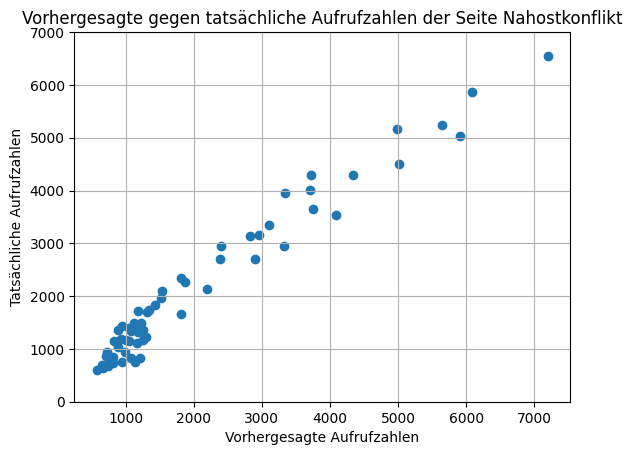

In [112]:
plt.scatter(pred_nahost, actual_nahost)
plt.grid()
plt.ylim(0,7000)
plt.title("Vorhergesagte gegen tatsächliche Aufrufzahlen der Seite Nahostkonflikt")
plt.xlabel("Vorhergesagte Aufrufzahlen")
plt.ylabel("Tatsächliche Aufrufzahlen")

In [113]:
fw = getOrderedLinks('https://de.wikipedia.org/wiki/Nahostkonflikt')
fw = filterLinks(fw)
fw = cutList(fw,30)

fw.extend(["X","Y","Z","vg"])

print(len(fw))

df = pd.DataFrame(training_nahost)
df = df.T
df.index = fw

start_datum = '2023-01-01'
end_datum = '2023-10-30'
dates = pd.date_range(start=start_datum, end=end_datum, freq='D')
df.columns = dates

df

30


,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2023-10-21,2023-10-22,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-28,2023-10-29,2023-10-30
Israel,2037.0,2150.0,3001.0,2533.0,2246.0,2042.0,2025.0,2473.0,2168.0,2034.0,...,37385.0,42199.0,31583.0,28272.0,26711.0,26638.0,25398.0,29237.0,32543.0,28644.0
Gazastreifen,328.0,381.0,610.0,563.0,448.0,385.0,321.0,406.0,424.0,397.0,...,37878.0,40668.0,33712.0,24695.0,23152.0,22842.0,25576.0,32481.0,38578.0,31078.0
Westjordanland,472.0,530.0,815.0,655.0,526.0,498.0,522.0,475.0,495.0,438.0,...,13477.0,21061.0,12775.0,10698.0,10803.0,10074.0,10036.0,10241.0,11931.0,11743.0
Arabische Staaten,1.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arabische Liga,215.0,165.0,175.0,172.0,151.0,163.0,118.0,138.0,170.0,147.0,...,646.0,648.0,639.0,508.0,496.0,449.0,483.0,433.0,551.0,479.0
Palästina (Region),300.0,346.0,407.0,437.0,361.0,391.0,374.0,384.0,400.0,326.0,...,15246.0,15705.0,10671.0,8837.0,9684.0,10938.0,9883.0,11892.0,13614.0,12108.0
Juden,527.0,542.0,562.0,538.0,496.0,514.0,512.0,572.0,525.0,562.0,...,3397.0,4149.0,2691.0,2481.0,2226.0,2200.0,2247.0,2367.0,3067.0,3176.0
Araber,214.0,238.0,231.0,288.0,285.0,249.0,272.0,291.0,224.0,296.0,...,804.0,975.0,710.0,690.0,649.0,675.0,643.0,856.0,858.0,734.0
Arabisch-israelische Kriege,28.0,30.0,19.0,29.0,35.0,48.0,59.0,71.0,134.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Naher Osten,221.0,290.0,338.0,391.0,304.0,330.0,266.0,283.0,358.0,372.0,...,1150.0,1403.0,1120.0,987.0,933.0,905.0,867.0,814.0,868.0,780.0


In [114]:
df = pd.DataFrame(y_nahost)
df.index = dates
df.columns = ["Nahostkonflikt"]
df

,Nahostkonflikt
2023-01-01,196
2023-01-02,263
2023-01-03,369
2023-01-04,328
2023-01-05,337
...,...
2023-10-26,5917
2023-10-27,5620
2023-10-28,5994
2023-10-29,6732


# Robert Oppenheimer

In [115]:
tupel_opp = getTrainingsdata("Robert Oppenheimer")
training_opp = tupel_opp[0]
y_opp = tupel_opp[1]

test_opp = getTestdaten("Robert Oppenheimer")
#test_olaf

mod_opp = buildModel(training_opp, y_opp)
pred_opp = mod_opp.predict(test_opp)
actual_opp = getActualData("Robert Oppenheimer")

print(actual_opp)
print(pred_opp)

[2665, 2339, 2372, 3240, 2917, 2032, 1915, 1838, 3484, 5188, 6815, 7096, 4176, 3517, 3250, 3281, 4180, 5698, 6818, 3888, 3107, 7933, 8073, 10056, 15388, 16630, 8404, 6061, 5981, 5434, 6948, 10811, 10898, 5781, 4636, 4645, 4653, 6690, 8671, 8880, 5926, 4739, 3957, 3699, 4494, 6633, 6288, 4264, 3489, 3352, 5518, 7628, 10761, 9759, 17375, 17663, 13869, 12712, 12426, 15078, 12856]
[ 2731.1948999   2803.40198349  2983.92036564  3033.16505009
  3773.19332635  2342.62663201  2517.56407948  2212.3224377
  3644.89488996  4624.14511186  5464.46447658  6439.50493516
  8775.61597305  4080.0429737   3292.81329698  2990.10863453
  3348.32886557  4783.23295262  7628.39669722  5112.00140029
  4197.28137575 12706.35402518  9333.84017248  9632.29454546
 13569.05874976 16009.50206458  8194.53646103  5590.36664115
  5507.78006725  4730.31097026  6003.79123174  8163.3643045
  9680.49096675  5387.40426227  4227.50006128  3873.79775828
  4282.89350627  6530.50921588  8056.36386858  8629.18970066
  5633.32843

In [116]:
df = pd.DataFrame(actual_opp)
df.to_csv('actual_opp.csv', index=False)

Text(0, 0.5, 'Tatsächliche Aufrufzahlen')

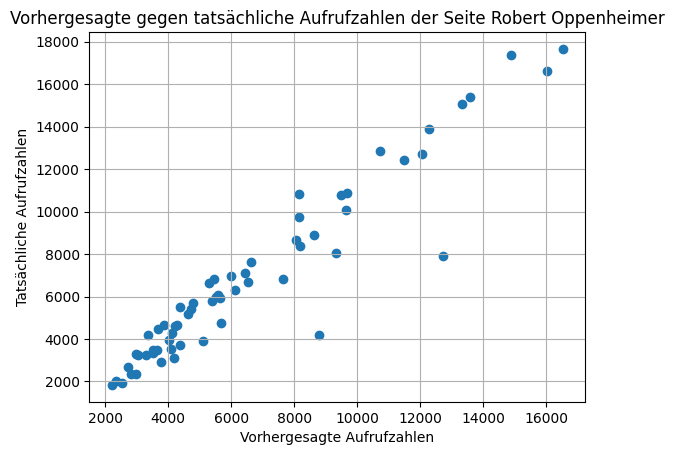

In [117]:
plt.scatter(pred_opp,actual_opp)
plt.grid()
#plt.xlim(250,2000)
#plt.ylim(250,2000)
plt.title("Vorhergesagte gegen tatsächliche Aufrufzahlen der Seite Robert Oppenheimer")
plt.xlabel("Vorhergesagte Aufrufzahlen")
plt.ylabel("Tatsächliche Aufrufzahlen")

In [118]:
print(mod_nahost.score(training_nahost, y_nahost))
#print(mod_olaf.score(training_olaf, y_olaf))
print("")
print(mod_opp.score(training_opp, y_opp))

0.9959857178413456

0.9978947089168133


In [119]:
pred_nahost = pred_nahost/(1.029)
print(actual_nahost)
print(pred_nahost)

[6547, 5859, 5249, 4494, 5025, 5171, 4301, 4007, 3652, 3164, 2942, 3541, 4297, 3957, 3345, 3133, 2708, 2131, 2697, 2948, 2263, 2343, 2090, 1840, 1220, 1652, 1955, 1731, 1703, 1717, 1437, 944, 1110, 1496, 1487, 1392, 1332, 1146, 840, 1169, 1329, 1387, 1366, 1359, 1038, 778, 1176, 1188, 1148, 951, 872, 695, 750, 746, 825, 831, 726, 684, 599, 690, 632]
[6994.18874261 5914.32136789 5478.80528717 4868.25722491 5737.16893087
 4838.07510005 4215.88880364 3605.91749217 3649.29293681 2879.81218417
 3229.65087663 3969.86050152 3620.35952026 3237.51666896 3012.07789797
 2743.20934648 2322.96087073 2137.22403589 2811.68489225 2331.86013499
 1819.76418637 1754.97862918 1486.51830344 1396.13352218 1261.99440996
 1760.76799812 1475.27998377 1308.28068125 1278.65156625 1149.39297154
  922.83850206  967.29912126 1133.21588395 1190.76006044 1093.47073416
 1019.82857322 1043.4448375  1013.66854854  793.52537353 1216.27898375
 1144.62088633 1154.34497445 1218.47982809  857.45197297  862.72267048
  781.377

# New York

In [120]:
# Dateipfad zur CSV-Datei
csv_dateipfad = 'ml_training_data.csv'

# CSV-Datei in ein DataFrame laden
ny_df = pd.read_csv(csv_dateipfad)
ny_df

,input,output
0,"[1556.0, 174.0, 22.0, 44.0, 108.0, 221.0, 4378...",684.0
1,"[1981.0, 159.0, 28.0, 70.0, 115.0, 179.0, 4792...",577.0
2,"[1800.0, 96.0, 19.0, 67.0, 79.0, 174.0, 4872.0...",537.0
3,"[1715.0, 119.0, 20.0, 76.0, 88.0, 182.0, 5710....",465.0
4,"[1776.0, 114.0, 39.0, 75.0, 107.0, 177.0, 4933...",527.0
...,...,...
9295,"[1954.0, 4.0, 2267.0, 167.0, 2.0, 2.0, 835.0, ...",1.0
9296,"[1861.0, 3.0, 2135.0, 155.0, 3.0, 2.0, 789.0, ...",0.0
9297,"[1993.0, 3.0, 2068.0, 151.0, 2.0, 1.0, 812.0, ...",1.0
9298,"[2257.0, 5.0, 1934.0, 85.0, 1.0, 1.0, 787.0, 6...",0.0


In [121]:
total_input = []
total_output = []
for index, row in ny_df.iterrows():
    input = row['input']
    output = row['output']
    input = ast.literal_eval(input)
    total_input.append(input)
    total_output.append(output)

mod_ny = buildModel(total_input, total_output)
print(total_input)
print(total_output)

[[1556.0, 174.0, 22.0, 44.0, 108.0, 221.0, 4378.0, 228.0, 186.0, 37.0, 8.0, 1003.0, 522.0, 101.0, 22.0, 133.0, 40.0, 57.0, 36.0, 0.0, 15.0, 61.0, 1718.0, 89.0, 53.0, 989.0, 26.0, 238.0, 84.0, 0.0], [1981.0, 159.0, 28.0, 70.0, 115.0, 179.0, 4792.0, 200.0, 226.0, 31.0, 4.0, 1033.0, 468.0, 137.0, 18.0, 90.0, 25.0, 48.0, 42.0, 0.0, 17.0, 102.0, 1589.0, 86.0, 46.0, 1026.0, 40.0, 326.0, 57.0, 0.0], [1800.0, 96.0, 19.0, 67.0, 79.0, 174.0, 4872.0, 161.0, 209.0, 14.0, 3.0, 736.0, 422.0, 111.0, 26.0, 73.0, 19.0, 63.0, 20.0, 0.0, 8.0, 160.0, 1440.0, 58.0, 31.0, 985.0, 50.0, 321.0, 57.0, 0.0], [1715.0, 119.0, 20.0, 76.0, 88.0, 182.0, 5710.0, 160.0, 191.0, 27.0, 2.0, 673.0, 454.0, 115.0, 36.0, 78.0, 19.0, 44.0, 17.0, 0.0, 14.0, 354.0, 1424.0, 53.0, 40.0, 1395.0, 27.0, 270.0, 60.0, 0.0], [1776.0, 114.0, 39.0, 75.0, 107.0, 177.0, 4933.0, 188.0, 159.0, 19.0, 5.0, 681.0, 434.0, 97.0, 38.0, 89.0, 24.0, 52.0, 8.0, 0.0, 14.0, 1601.0, 1518.0, 63.0, 52.0, 1046.0, 44.0, 295.0, 65.0, 0.0], [1481.0, 140.0, 29.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(total_input, total_output, test_size=0.2, random_state=0)
#mod_köln.fit(X_train, y_train)
mod_ny = buildModel(X_train, y_train)
y_pred = mod_ny.predict(X_test)
print(y_pred)
print(y_test)
print(mod_ny.score(X_train, y_train))

[ -0.62240192 -12.27018802   2.01892931 ...  88.4504867   34.424885
  89.88589473]
[15.0, 0.0, 2.0, 1.0, 1.0, 0.0, 561.0, 0.0, 103.0, 49.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 606.0, 120.0, 0.0, 0.0, 524.0, 0.0, 28.0, 4.0, 164.0, 6.0, 0.0, 9.0, 0.0, 1.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 12.0, 21.0, 1.0, 0.0, 5.0, 5.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0, 3.0, 0.0, 1.0, 33.0, 0.0, 12.0, 0.0, 3.0, 3.0, 7.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 1.0, 16.0, 1.0, 1.0, 0.0, 2.0, 0.0, 3.0, 2.0, 27.0, 204.0, 0.0, 1.0, 0.0, 0.0, 0.0, 4.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 10.0, 1.0, 35.0, 2.0, 1.0, 18.0, 3.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 4.0, 6.0, 0.0, 64.0, 6.0, 6.0, 0.0, 0.0, 1.0, 119.0, 0.0, 13.0, 25.0, 0.0, 0.0, 0.0, 30.0, 6.0, 0.0, 24.0, 139.0, 3.0, 1.0, 0.0, 3.0, 0.0, 0.0, 2.0, 1.0, 7.0, 0.0, 0.0, 9.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 5.0, 0.0, 3.0, 4.0, 2.0, 3.0, 162.0, 38.0, 0.0, 0.0, 0.0, 4.0, 

Text(0, 0.5, 'Tatsächliche Aufrufzahlen')

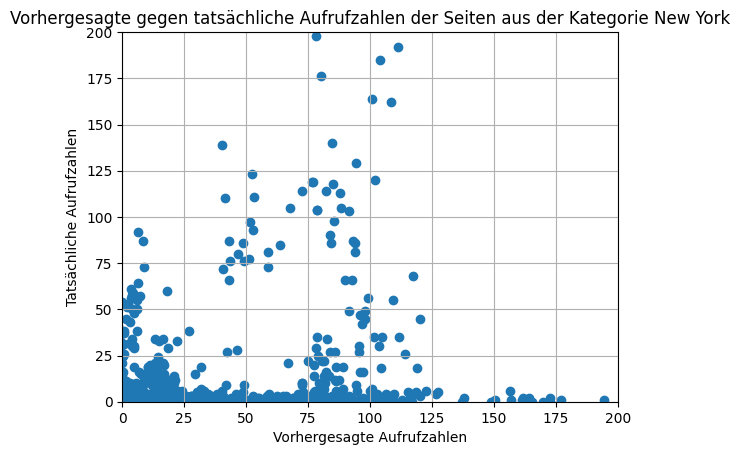

In [123]:
plt.scatter(y_pred,y_test)
plt.grid()
plt.xlim(0,200)
plt.ylim(0,200)
plt.title("Vorhergesagte gegen tatsächliche Aufrufzahlen der Seiten aus der Kategorie New York")
plt.xlabel("Vorhergesagte Aufrufzahlen")
plt.ylabel("Tatsächliche Aufrufzahlen")

# Mean Absolute Error

In [124]:
print(mean_absolute_error(actual_nahost, pred_nahost))
print(mean_absolute_error(actual_bonn, pred_bonn))
print(mean_absolute_error(actual_ki, pred_ki))
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_error(actual_opp, pred_opp))


alte_daten = [278.175628956579,
              84.9986858308055
              ,166.6783911539797
              ,30.090207425348932]

278.175628956579
84.9986858308055
215.6759064193557
31.48954592381787
908.9736319596785


# Mean Squared Error

In [125]:
print(mean_squared_error(actual_nahost, pred_nahost))
print(mean_squared_error(actual_bonn, pred_bonn))
print(mean_squared_error(actual_ki, pred_ki))
print(mean_squared_error(actual_opp, pred_opp))
print("")


pred_ny = mod_ny.predict(total_input)
print(mean_squared_error(y_test, y_pred))

#pred_nahost = mod_köln.predict(test_nahost)
#pred_bonn = mod_köln.predict(test_bonn)
#pred_ki = mod_köln.predict(test_ki)

117216.80452594064
70867.38893884313
71183.4297570879
1648597.120103393

6182.781719011377


In [126]:
print(np.var(actual_nahost)/len(actual_nahost))
print(sum(actual_nahost)/len(actual_nahost))
print("")
print(np.var(actual_bonn)/len(actual_bonn))
print(sum(actual_bonn)/len(actual_nahost))
print("")
print(np.var(total_output)/len(total_output))
print(sum(total_output)/len(total_output))

35963.79222049423
2127.9508196721313

1254.9483965618267
921.983606557377

0.7273588700974815
19.439247311827955


# Root Mean Squared Error

In [127]:
print(root_mean_squared_error(actual_nahost, pred_nahost))
print(root_mean_squared_error(actual_bonn, pred_bonn))
print(root_mean_squared_error(actual_ki, pred_ki))
print(root_mean_squared_error(actual_opp, pred_opp))
print(root_mean_squared_error(y_test, y_pred))

alte_daten = [  342.3693977649589,
                266.2092953652128,
                206.6906297987793,
                72.88315706505485]

342.3693977649589
266.2092953652128
266.8022296703832
1283.977071486634
78.63066653037717
